# Chapter 3

## Import Libraries

In [59]:
"""Bayesian way"""
import arviz as az
import stan

"""Basic ones"""
import polars as pl
from plotnine import *
import matplotlib.pyplot as plt
plt.show()  # for display figures after ggplot
# plt.rcParams['axes.grid'] = True
import numpy as np
import seaborn as sns
import pandas
import statsmodels.api as sm
from datetime import datetime
import random

import warnings
warnings.simplefilter("ignore")

## ARモデル

- 一次のARモデルはAR(1)と表記され，次式になる

    $y_t = c + \phi_1 y_{t-1} + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma^2)$
        
    cを定数項，$\phi_1$を係数と呼ぶ．

- 過去の自分が説明変数になるのが特徴．

- p時点前までのデータを使うARモデルはAR(p)で

    $y_t = c + \sum^p_{i=1}{\phi_i y_{t-i}} + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma^2)$

    となる

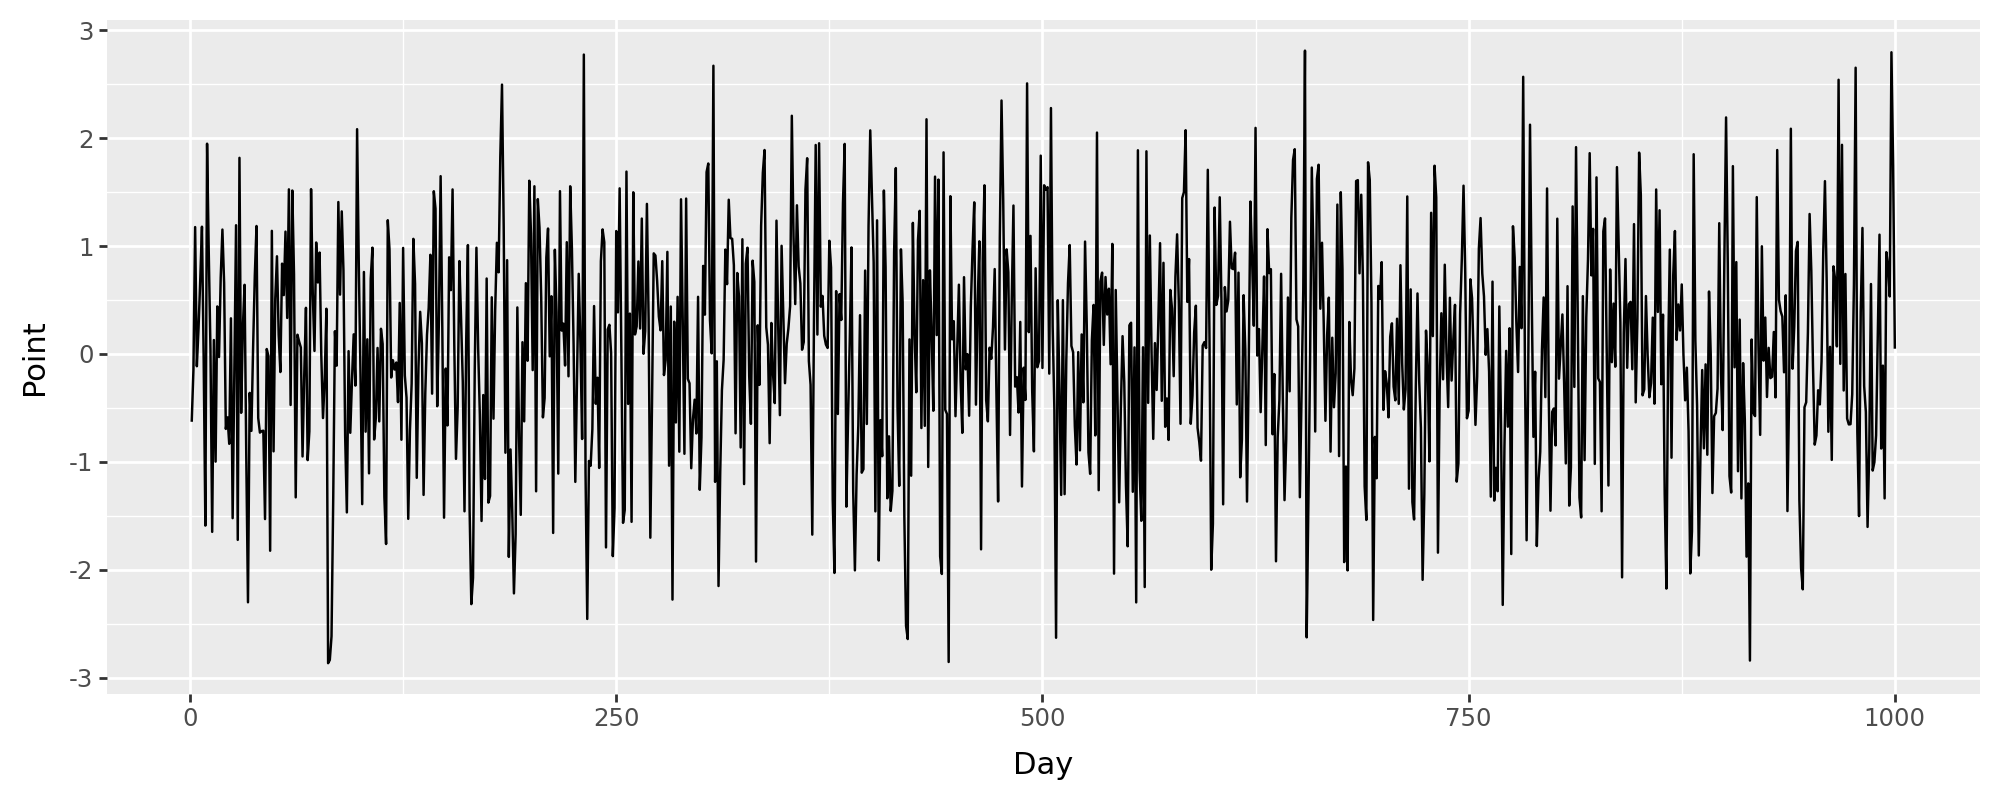

In [60]:
# AR(1), let's say y means points of something while 1 day to 1000 day
T = 1000
c = 0.01 # constant
phi_1 = 0.1 # coef
sigma = 1 # for epsilon
mu = 0 # for epsilon
epsilon = np.random.normal(mu, sigma, T) # noise
y = np.zeros(T)
y[0] = c + epsilon[0]
for t in range(1, T):
    y[t] = c + phi_1 * y[t-1] + epsilon[t]

(
    ggplot()
    + geom_line(aes(x=range(1, T+1), y=y))
    + theme(figure_size=(10, 4))
    + xlab("Day") + ylab("Point")
)

AR(1)過程の条件付き期待値は $E(y_t | y_{t-1}) = 0.01 + 0.1*y_{t-1}$ と表せる．ノイズ $\epsilon_t$ は期待値0だから無視できる．

条件付き確率分布は $p(y_t|y_{t-1}) = N(0.01 + 0.1 * y_{t-1}, 1)$ と表せる．AR(1)過程では，1時点前の値が決まると次の値の確率分布が変わるってこと．

AR(1)過程で，係数 $\phi_1$が0の時ホワイトノイズになり，1の時ランダムウォークになる．

係数 $\phi_1 < 1$ の時，時間がたつにつれて過去のデータの影響が0に近くなる．

係数 $\phi_1 \geq 1$ の時，時間がどれだけたっても影響がゼロになることはない．

係数が1未満かどうかはデータの特徴を大きくつける．

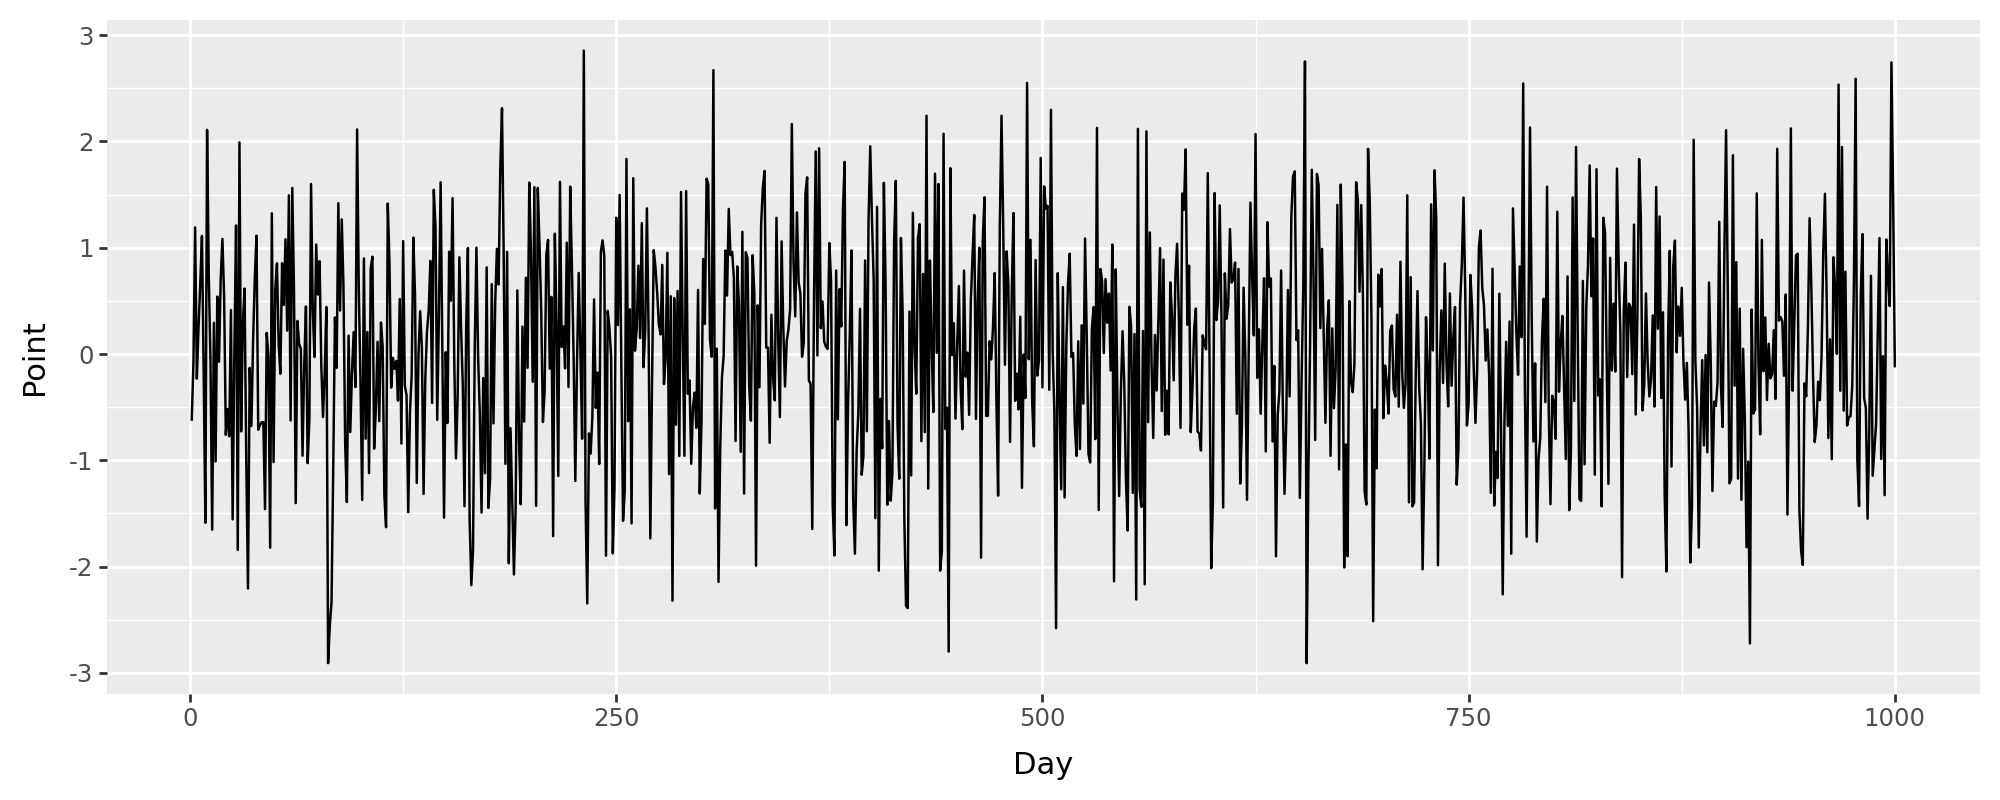

In [61]:
phi_1 = 0 # white noise
y = np.zeros(T)
y[0] = c + epsilon[0]
for t in range(1, T):
    y[t] = c + phi_1 * y[t-1] + epsilon[t]

(
    ggplot()
    + geom_line(aes(x=range(1, T+1), y=y))
    + theme(figure_size=(10, 4))
    + xlab("Day") + ylab("Point")
)

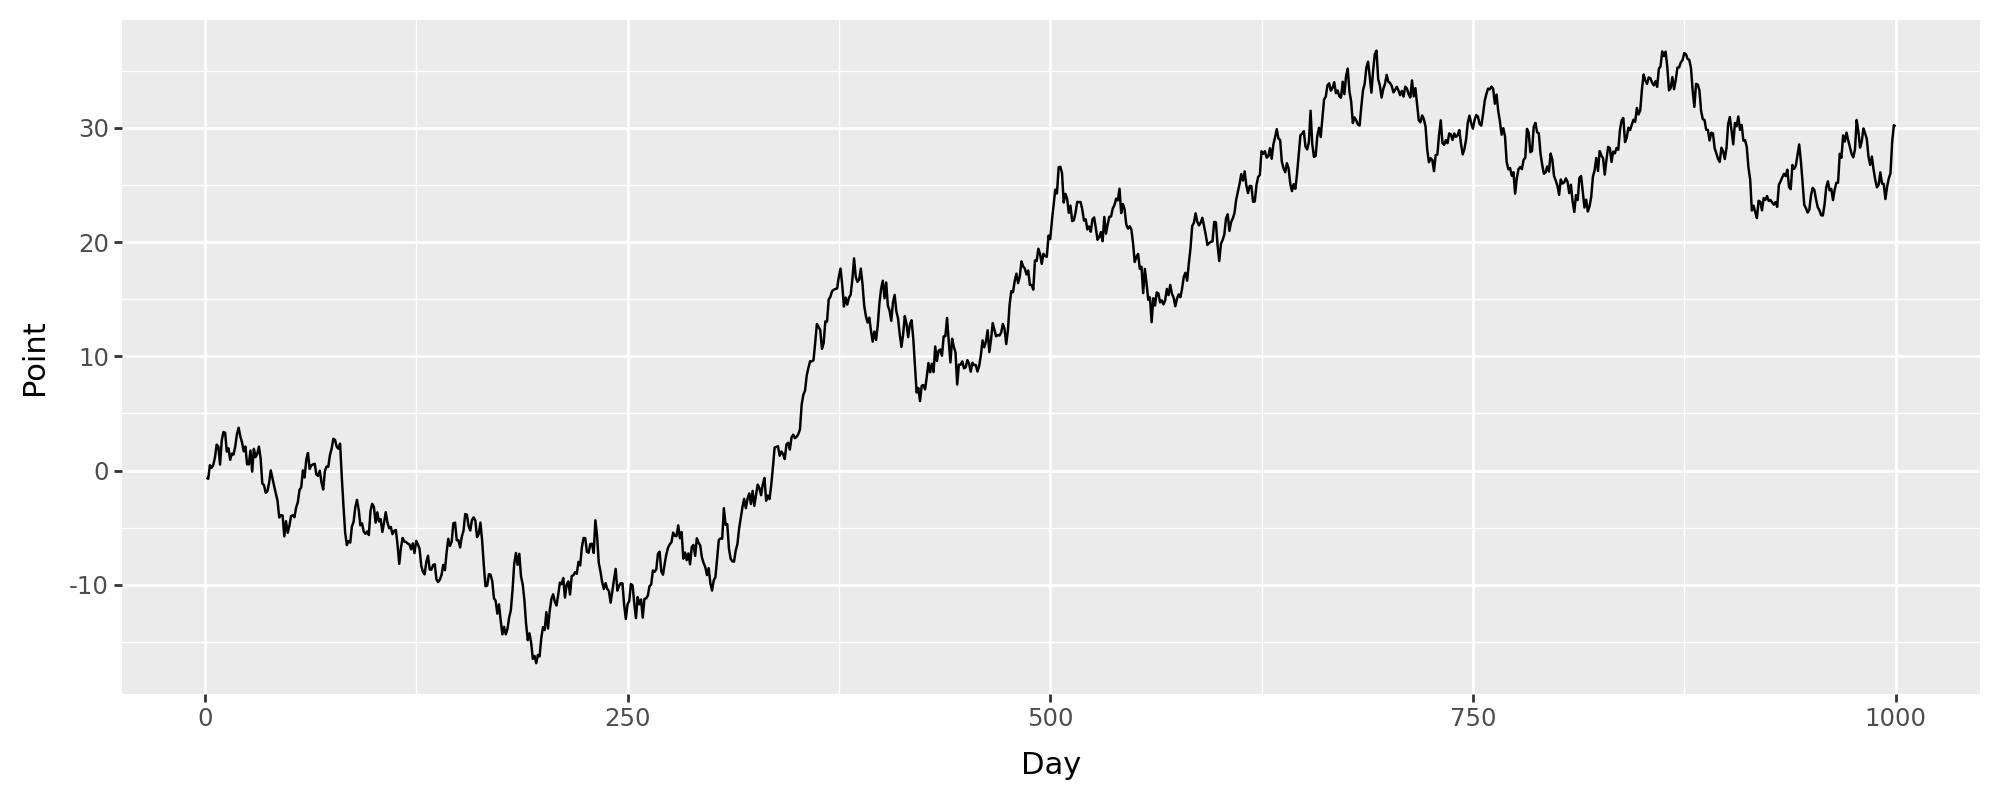

In [62]:
phi_1 = 1 # random walk
y = np.zeros(T)
y[0] = c + epsilon[0]
for t in range(1, T):
    y[t] = c + phi_1 * y[t-1] + epsilon[t]

(
    ggplot()
    + geom_line(aes(x=range(1, T+1), y=y))
    + theme(figure_size=(10, 4))
    + xlab("Day") + ylab("Point")
)

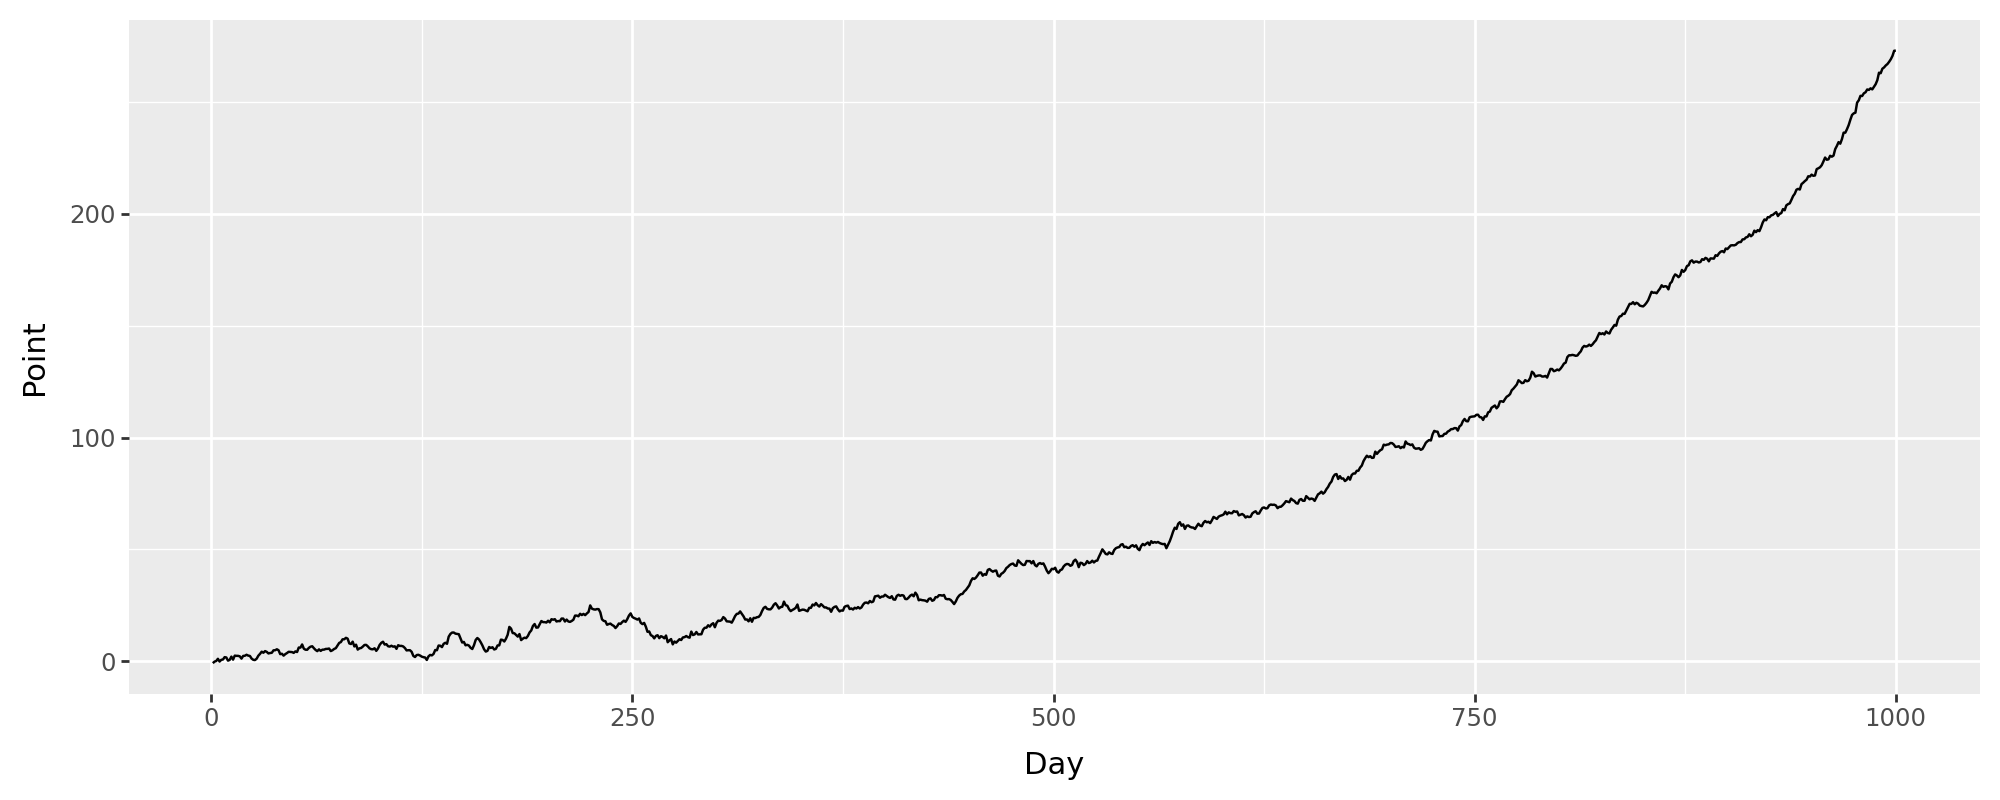

In [74]:
phi_1 = 1.004 # getting pretty bigger or smaller
y = np.zeros(T)
y[0] = c + epsilon[0]
for t in range(1, T):
    y[t] = c + phi_1 * y[t-1] + epsilon[t]

(
    ggplot()
    + geom_line(aes(x=range(1, T+1), y=y))
    + theme(figure_size=(10, 4))
    + xlab("Day") + ylab("Point")
)

係数の正負によっても特徴が変わる

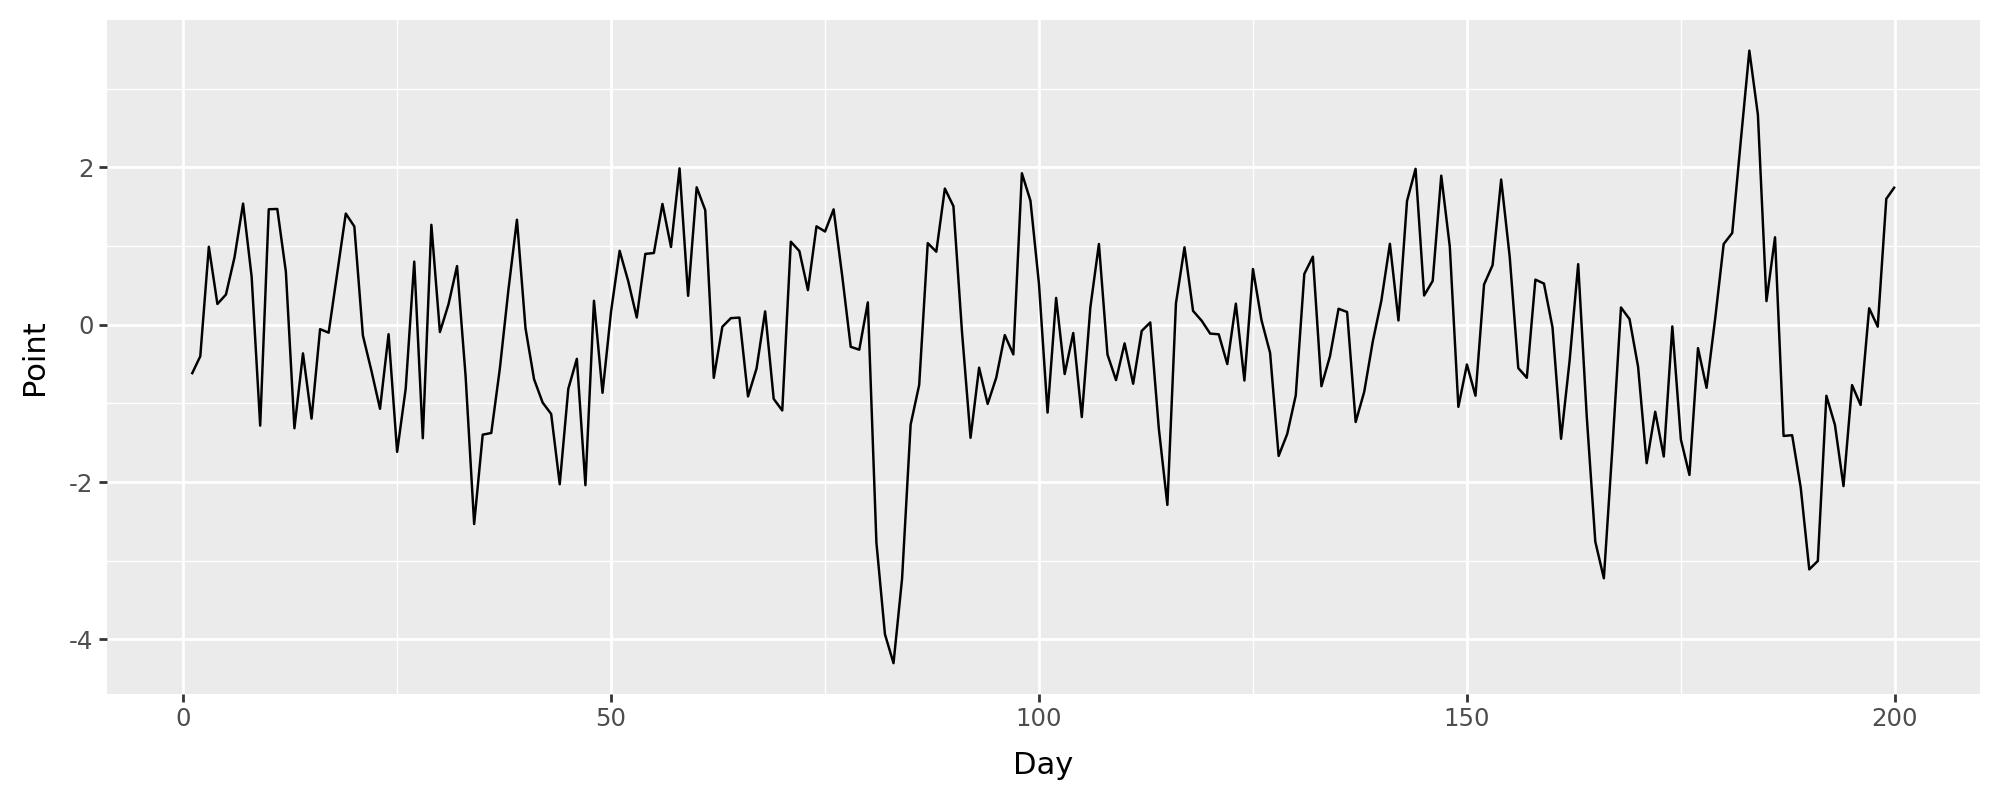

In [64]:
T = 200
phi_1 = 0.5 # positive
y = np.zeros(T)
y[0] = c + epsilon[0]
for t in range(1, T):
    y[t] = c + phi_1 * y[t-1] + epsilon[t]

(
    ggplot()
    + geom_line(aes(x=range(1, T+1), y=y))
    + theme(figure_size=(10, 4))
    + xlab("Day") + ylab("Point")
)

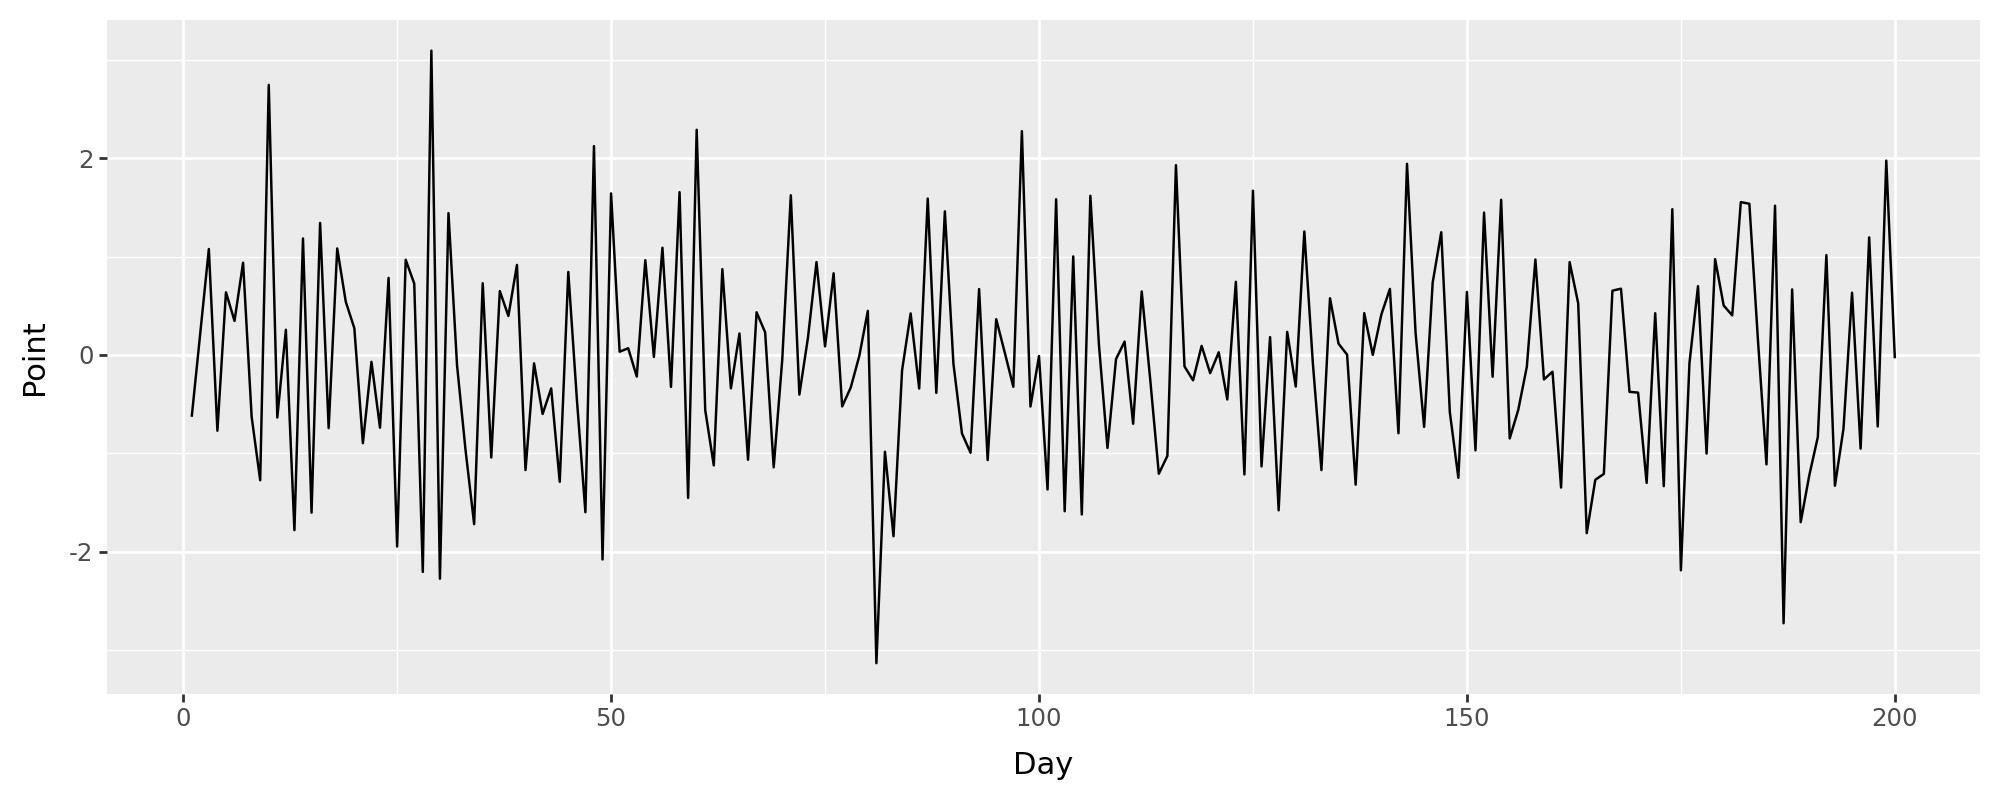

In [65]:
phi_1 = -0.5 # negative
y = np.zeros(T)
y[0] = c + epsilon[0]
for t in range(1, T):
    y[t] = c + phi_1 * y[t-1] + epsilon[t]

(
    ggplot()
    + geom_line(aes(x=range(1, T+1), y=y))
    + theme(figure_size=(10, 4))
    + xlab("Day") + ylab("Point")
)

負の係数を持つモデルだと，増加と減少を繰り返すためギザギザした形になる

## MAモデル

- 自己相関を表現するモデルの一つ，同じ値を使うことで自己相関を表現する．

- q次のMAモデルは次式で表現される
  
  $y_t = \mu + \sum^q_{j=1}{\theta_j \epsilon_{t-j}} + \epsilon_t \quad \epsilon_t \sim N(0, \sigma^2)$

- 例えば過去2時点分のノイズを使うとき，MA(2)と表記する．

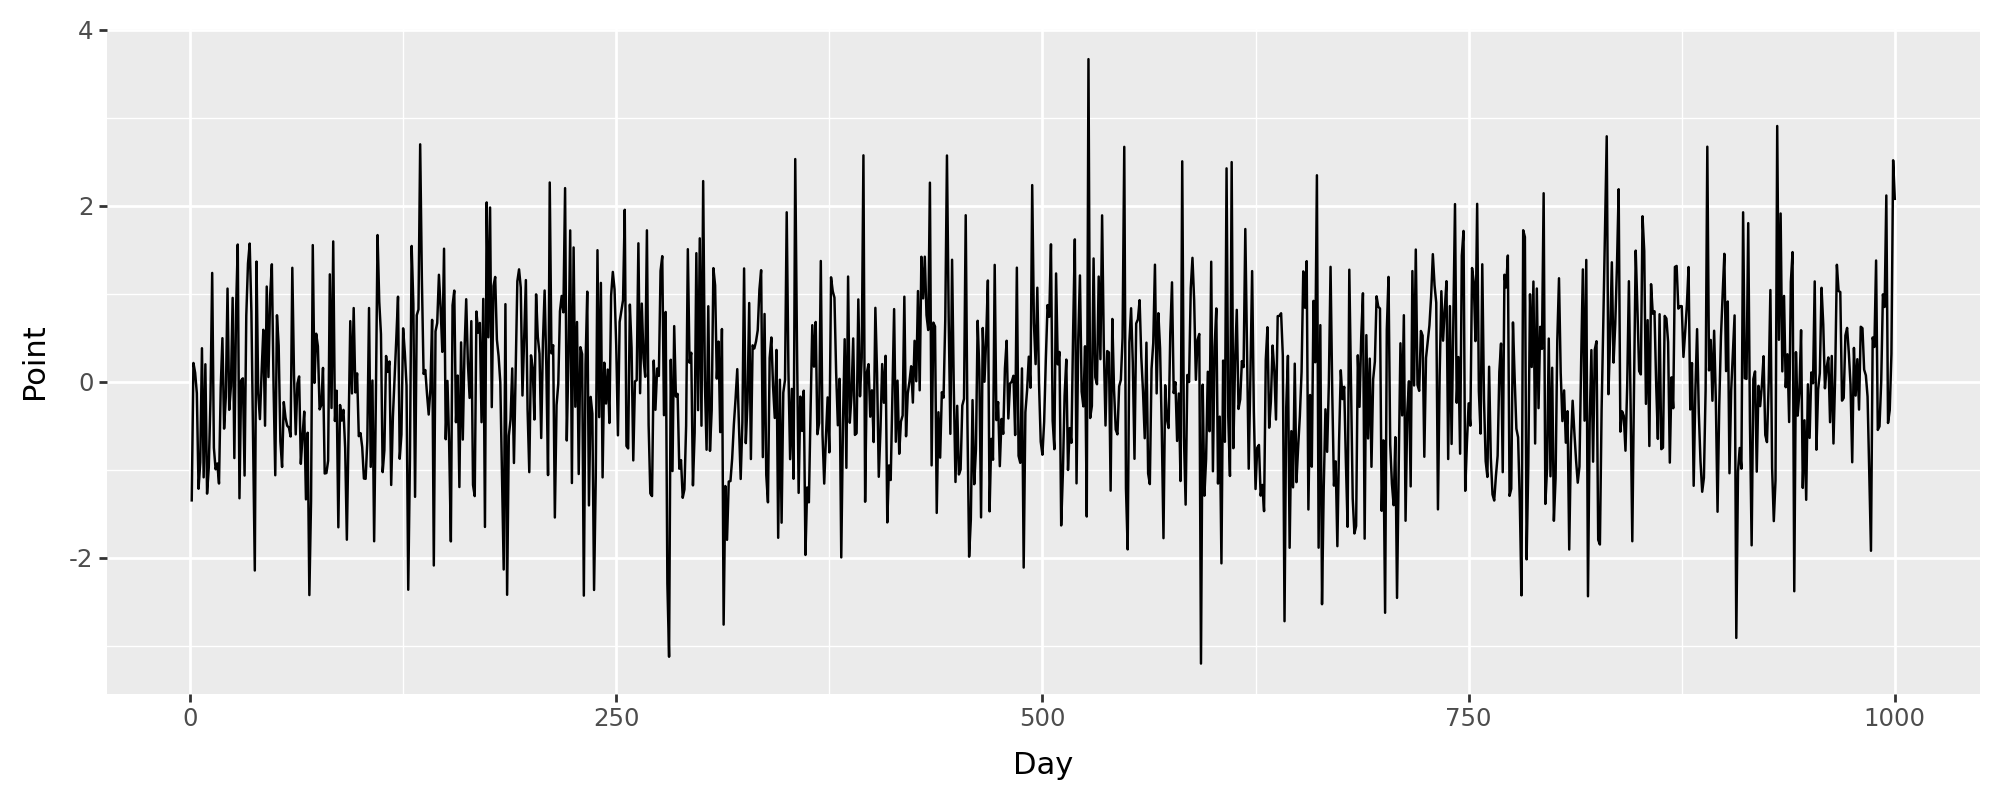

In [66]:
# MA(1)
T = 1000
mu = 0 # constant
theta = 0.1 # coef
sigma = 1 # for epsilon
mu_e = 0 # for epsilon
epsilon = np.random.normal(mu_e, sigma, T) # noise
y = np.zeros(T)
y[0] = mu + epsilon[0]
for t in range(1, T):
    y[t] = mu + theta * epsilon[t-1] + epsilon[t]

(
    ggplot()
    + geom_line(aes(x=range(1, T+1), y=y))
    + theme(figure_size=(10, 4))
    + xlab("Day") + ylab("Point")
)

## ARモデル，MAモデルのコレログラム

AR(1)とMA(1)のコレログラムの比較

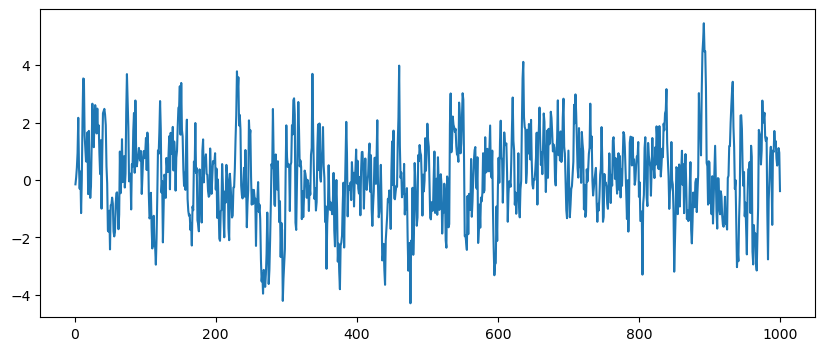

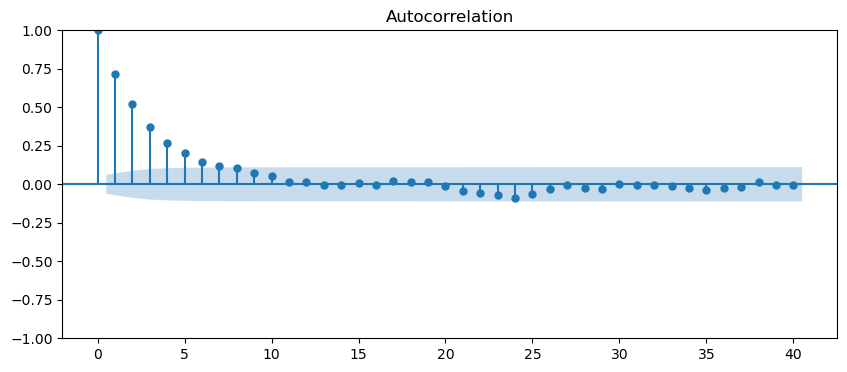

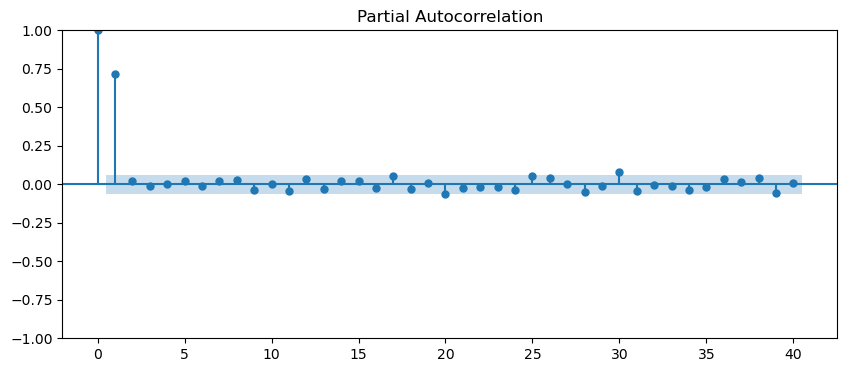

In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# AR(1)
T = 1000
c = 0 # constant
phi_1 = 0.7 # coef
sigma = 1 # for epsilon
mu = 0 # for epsilon
epsilon = np.random.normal(mu, sigma, T) # noise
y = np.zeros(T)
y[0] = c + epsilon[0]
for t in range(1, T):
    y[t] = c + phi_1 * y[t-1] + epsilon[t]
    
plt.figure(figsize=(10, 4));
plt.plot(range(1, T+1), y);
fig = plot_acf(y, lags=40)
fig.set_size_inches(10, 4); fig.show()
fig = plot_pacf(y, lags=40)
fig.set_size_inches(10, 4); fig.show()

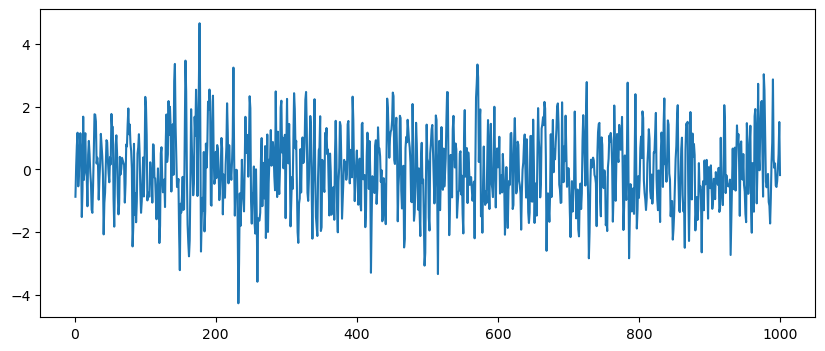

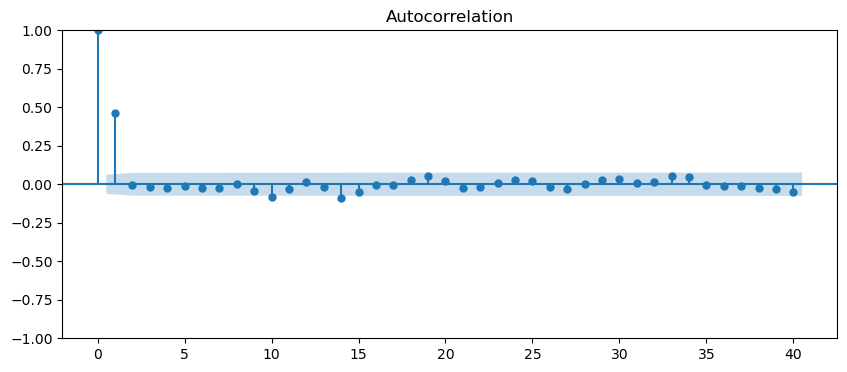

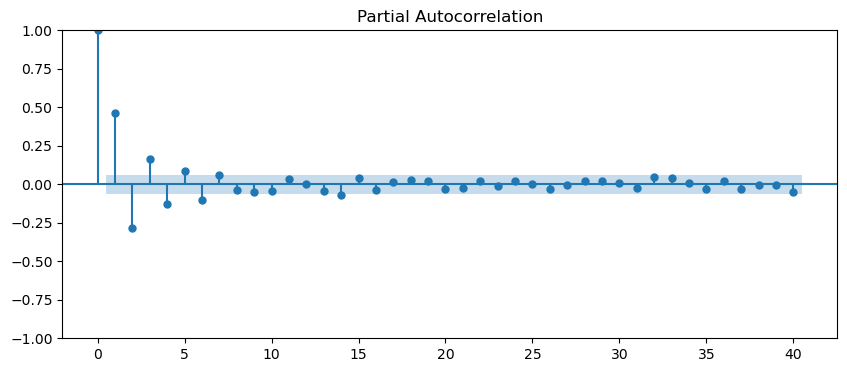

In [68]:
# MA(1)
T = 1000
mu = 0 # constant
theta = 0.7 # coef
sigma = 1 # for epsilon
mu_e = 0 # for epsilon
epsilon = np.random.normal(mu_e, sigma, T) # noise
y = np.zeros(T)
y[0] = mu + epsilon[0]
for t in range(1, T):
    y[t] = mu + theta * epsilon[t-1] + epsilon[t]

plt.figure(figsize=(10, 4));
plt.plot(range(1, T+1), y);
fig = plot_acf(y, lags=40)
fig.set_size_inches(10, 4); fig.show()
fig = plot_pacf(y, lags=40)
fig.set_size_inches(10, 4); fig.show()

AR(1)過程
- 自己相関は時間がたつにつれて緩やかに減少していく．
- 偏自己相関は急に0に近づく

MA(1)過程
- 自己相関は急に0に近づく
- 偏自己相関は時間がたつにつれて緩やかに減少していく

*グラフが美しくないのはやさしい目で見てください :)

## ARモデルとMAモデルの関係*

- 係数の絶対値が1より小さいAR(1)過程はMA($\infty$)過程で表せる．証明は知らない．
- もしARモデルがMAモデルで表現できれば，そのARモデルは定常であるとみなせる．(MAモデルが常に定常だから．？？？)
- MAモデルが反転可能性を持つとき，そのMAモデルはAR($\infty$)で表現できる．

## ARモデルとMAモデルのお話*

- ARモデルが常に定常となるとは限らない．でも定常になるかどうかの条件があって，その定常条件を満たせばそのARモデルが定常といえる．p次のARモデルの定常条件は，以下の特性方程式の解の絶対値が1よりも大きいことである

    $1 - \phi_1 z - \dots - \phi_p z^p = 0$

    例えば，AR(1)は $|\phi_1| < 1$ の時，定常になる．

あんまりよくわかってない:(

- MAモデルの反転可能性を満たす条件は以下の特性方程式の解の絶対値が1よりも大きいことである

    $1 + \theta_1 z + \dots + \theta_p z^p = 0$

    例えばMA(1)の反転可能条件は，$|\theta_1| < 1$ となる．

    反転可能性を満たすと，$\epsilon_t$ の大小を過去のデータから判断できる，らしい

何だこりゃ:(

上記二つのトピックは京都大学のある講義ノートにもっと詳細なことが書いてある．[ここ](https://www.nishiyama.kier.kyoto-u.ac.jp/2017/jugyochukei6.pdf)

## ARMAモデルとARIMAモデル

- ARモデルとMAモデルを組み合わせることで，自己相関を柔軟に表現できるようになる!
- ARモデルとMAモデルを組み合わせたものをARMAモデルっていう．(名前はつなげただけだからなんだか単純)
- p次のARモデルとq次のMAモデルを使ったARMAモデルはARMAモデル(p, q)と書かれ以下で表される

    $y_t = c + \sum^p_{i=1}{\phi_i y_{t-i}} + \epsilon_t + \sum^q_{j=1}{\theta_j \epsilon_{t-j}} \quad \epsilon_t \sim N(0, \sigma^2)$

    最初の総和部分がARモデルの部分で，次の総和部分がMAモデルの部分を表してる．

- 非定常過程にはARMAモデルを使えない...
- でも和分過程なら差分をとることで非定常過程を定常過程に変換することができる．ってことで，差分をとって定常過程に変換してからARMAモデルを適用することを考える．
- そのようなモデルをARIMAモデルっていう．
- d階和分過程 I(d)においてARMA(p, q)を適用する場合のARIMAモデルを ARIMA(p, d, q)と表記する．